In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np 
from scipy.interpolate import interp1d
import matplotlib.cm as cm
from scipy.signal import savgol_filter

import healpy as hp
from scipy.stats import poisson

from cnb_utils import read_files, read_Cl_CMB, compute_power_spectrum, compute_avg_hannestad, generate_poisson_fluctuations

mpl.rcParams.update({
    'text.usetex': True,                  # Use LaTeX for text rendering
    'font.family': 'serif',               # Set font family to serif
    'font.serif': ['cmr10'],              # Use Computer Modern Roman for LaTeX math
    'axes.labelsize': 21,                 # Font size for axis labels
    'axes.linewidth': 1.5,                # Axis line thickness
    'xtick.labelsize': 15,                # Font size for x-tick labels
    'ytick.labelsize': 15,                # Font size for y-tick labels
    'legend.fontsize': 17,                # Font size for legend text
    'font.size': 17,
    'legend.frameon': False,              # Remove the box around the legend
    'axes.formatter.use_mathtext': True   # Use mathtext for labels
})

As = 2.0968e-09
ns = 0.9652
lmax = 17
k_output_values = 1.00e-04, 1.10e-04, 1.21e-04, 1.32e-04, 1.45e-04, 1.59e-04, 1.75e-04, 1.92e-04, 2.11e-04, 2.32e-04, 2.54e-04, 2.79e-04, 3.07e-04, 3.37e-04, 3.69e-04, 4.06e-04, 4.45e-04, 4.89e-04, 5.37e-04, 5.89e-04, 6.47e-04, 7.10e-04, 7.80e-04, 8.56e-04, 9.40e-04, 1.03e-03, 1.13e-03, 1.24e-03, 1.37e-03, 1.50e-03, 1.65e-03, 1.81e-03, 1.98e-03, 2.18e-03, 2.39e-03, 2.62e-03, 2.88e-03, 3.16e-03, 3.47e-03, 3.81e-03, 4.18e-03, 4.59e-03, 5.04e-03, 5.54e-03, 6.08e-03, 6.67e-03, 7.33e-03, 8.04e-03, 8.83e-03, 9.69e-03, 1.06e-02, 1.17e-02, 1.28e-02, 1.41e-02, 1.55e-02, 1.70e-02, 1.86e-02, 2.05e-02, 2.25e-02, 2.47e-02, 2.71e-02, 2.97e-02, 3.26e-02, 3.58e-02, 3.93e-02, 4.32e-02, 4.74e-02, 5.20e-02, 5.71e-02, 6.27e-02, 6.88e-02, 7.56e-02, 8.30e-02, 9.11e-02, 1.00e-01

Quantities interpolated over momenta will be evaluated on Nq_interp = 100 bins


In [2]:
root_dir = './output_CNB'

m_nuL = 0.03 # in eV
Gamma = [979.49, 293.85, 97.95] # in km/s/Mpc
is_ncdm_decay_degenerate = "no" #choose between "yes" or "no"

In [3]:
path_Cl = root_dir+'/testA2_stable_mL0p03_cl_lensed.dat'
l0, Cl_TT0, Cl_EE0 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testA2_g1000_mL0p03_cl_lensed.dat'
l1, Cl_TT1, Cl_EE1 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testA2_g300_mL0p03_cl_lensed.dat'
l2, Cl_TT2, Cl_EE2 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testA2_g100_mL0p03_cl_lensed.dat'
l3, Cl_TT3, Cl_EE3 = read_Cl_CMB(path_Cl)

In [4]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testA2_stable_mL0p03_background.dat'
    perturb_base_path = root_dir+'/testA2_stable_mL0p03_perturbations'

    q_ratio = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) 
    q_ratio2 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) 
 
    delta0, q_int0 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = False)
    Cl0 = compute_power_spectrum(delta0)
    f0 = (1./(np.exp(q_int0)+1.))
    Cl_avg0 = compute_avg_hannestad(f0, Cl0, m_nuL,q_int0)
    
    np.save('./Cl_avg/Cl_avg_A2_stable_mL0p03.npy',Cl_avg0)
else:
    Cl_avg0 = np.load('./Cl_avg/Cl_avg_A2_stable_mL0p03.npy')

In [5]:
%%time

N_total = int(1e5)
n_trials = 1000

nside = 128 
delta_map = hp.synfast(Cl_avg0, nside=nside)

maps_fluc_scaled, maps_fluc_unscaled, cls_fluc, ratios_fluc = generate_poisson_fluctuations(Cl_avg0, delta_map, n_trials, N_total)

cl_mean = np.mean(cls_fluc, axis=0)
cl_std = np.std(cls_fluc, axis=0)

CPU times: user 24.1 s, sys: 5.32 s, total: 29.4 s
Wall time: 16.5 s


In [6]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testA2_g1000_mL0p03_background.dat'
    perturb_base_path = root_dir+'/testA2_g1000_mL0p03_perturbations'

    q_ratio = np.array([0.428571,0.857143,1.28571,1.71429,2.14286,2.57143,3,3.42857,3.85714,4.28571,4.71429,5.14286,5.57143,6,6.42857,6.85714,7.28571,7.71429,8.14286,8.57143,9,9.42857,9.85714,10.2857,10.7143,11.1429,11.5714,12,12.4286,12.8571,13.2857,13.7143,14.1429,14.5714,15]) 
    q_ratio2 = np.array([0.428571,1.28571,2.14286,3.42857,4.28571,5.57143,6.42857,7.71429,8.57143,9.42857,10.7143,11.5714,12.8571,13.7143,15]) 
 
    f1, delta1, q_int1 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl1 = compute_power_spectrum(delta1)
    Cl_avg1 = compute_avg_hannestad(f1, Cl1, m_nuL, q_int1)
    
    np.save('./Cl_avg/Cl_avg_A2_g1000_mL0p03.npy',Cl_avg1)
else:
    Cl_avg1 = np.load('./Cl_avg/Cl_avg_A2_g1000_mL0p03.npy')    

In [7]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testA2_g300_mL0p03_background.dat'
    perturb_base_path = root_dir+'/testA2_g300_mL0p03_perturbations'

    q_ratio = np.array([0.75,1.5,2.25,3,3.75,4.5,5.25,6,6.75,7.5,8.25,9,9.75,10.5,11.25,12,12.75,13.5,14.25,15]) 
    q_ratio2 = np.array([0.75,1.5,2.25,3.75,4.5,5.25,6.75,7.5,8.25,9.75,10.5,11.25,12.75,13.5,15]) 
 
    f2, delta2, q_int2 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl2 = compute_power_spectrum(delta2)
    Cl_avg2 = compute_avg_hannestad(f2, Cl2, m_nuL, q_int2)
    
    np.save('./Cl_avg/Cl_avg_A2_g300_mL0p03.npy',Cl_avg2)
else:
    Cl_avg2 = np.load('./Cl_avg/Cl_avg_A2_g300_mL0p03.npy')

In [8]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testA2_g100_mL0p03_background.dat'
    perturb_base_path = root_dir+'/testA2_g100_mL0p03_perturbations'

    q_ratio = np.array([0.75,1.5,2.25,3,3.75,4.5,5.25,6,6.75,7.5,8.25,9,9.75,10.5,11.25,12,12.75,13.5,14.25,15]) 
    q_ratio2 = np.array([0.75,1.5,2.25,3.75,4.5,5.25,6.75,7.5,8.25,9.75,10.5,11.25,12.75,13.5,15]) 
 
    f3, delta3, q_int3 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl3 = compute_power_spectrum(delta3)
    Cl_avg3 = compute_avg_hannestad(f3, Cl3, m_nuL, q_int3)
    
    np.save('./Cl_avg/Cl_avg_A2_g100_mL0p03.npy',Cl_avg3)
else:
    Cl_avg3 = np.load('./Cl_avg/Cl_avg_A2_g100_mL0p03.npy')

In [9]:
lTT,DlTT_mean,DlTT_error_minus,DlTT_error_plus,DlTT_bestfit= np.loadtxt("error_Planck/Planck2018_errorTT.txt",unpack=True)
lEE,DlEE_mean,DlEE_error_minus,DlEE_error_plus,DlEE_bestfit= np.loadtxt("error_Planck/Planck2018_errorEE.txt",unpack=True)
lTE,DlTE_mean,DlTE_error_minus,DlTE_error_plus,DlTE_bestfit= np.loadtxt("error_Planck/Planck2018_errorTE.txt",unpack=True)

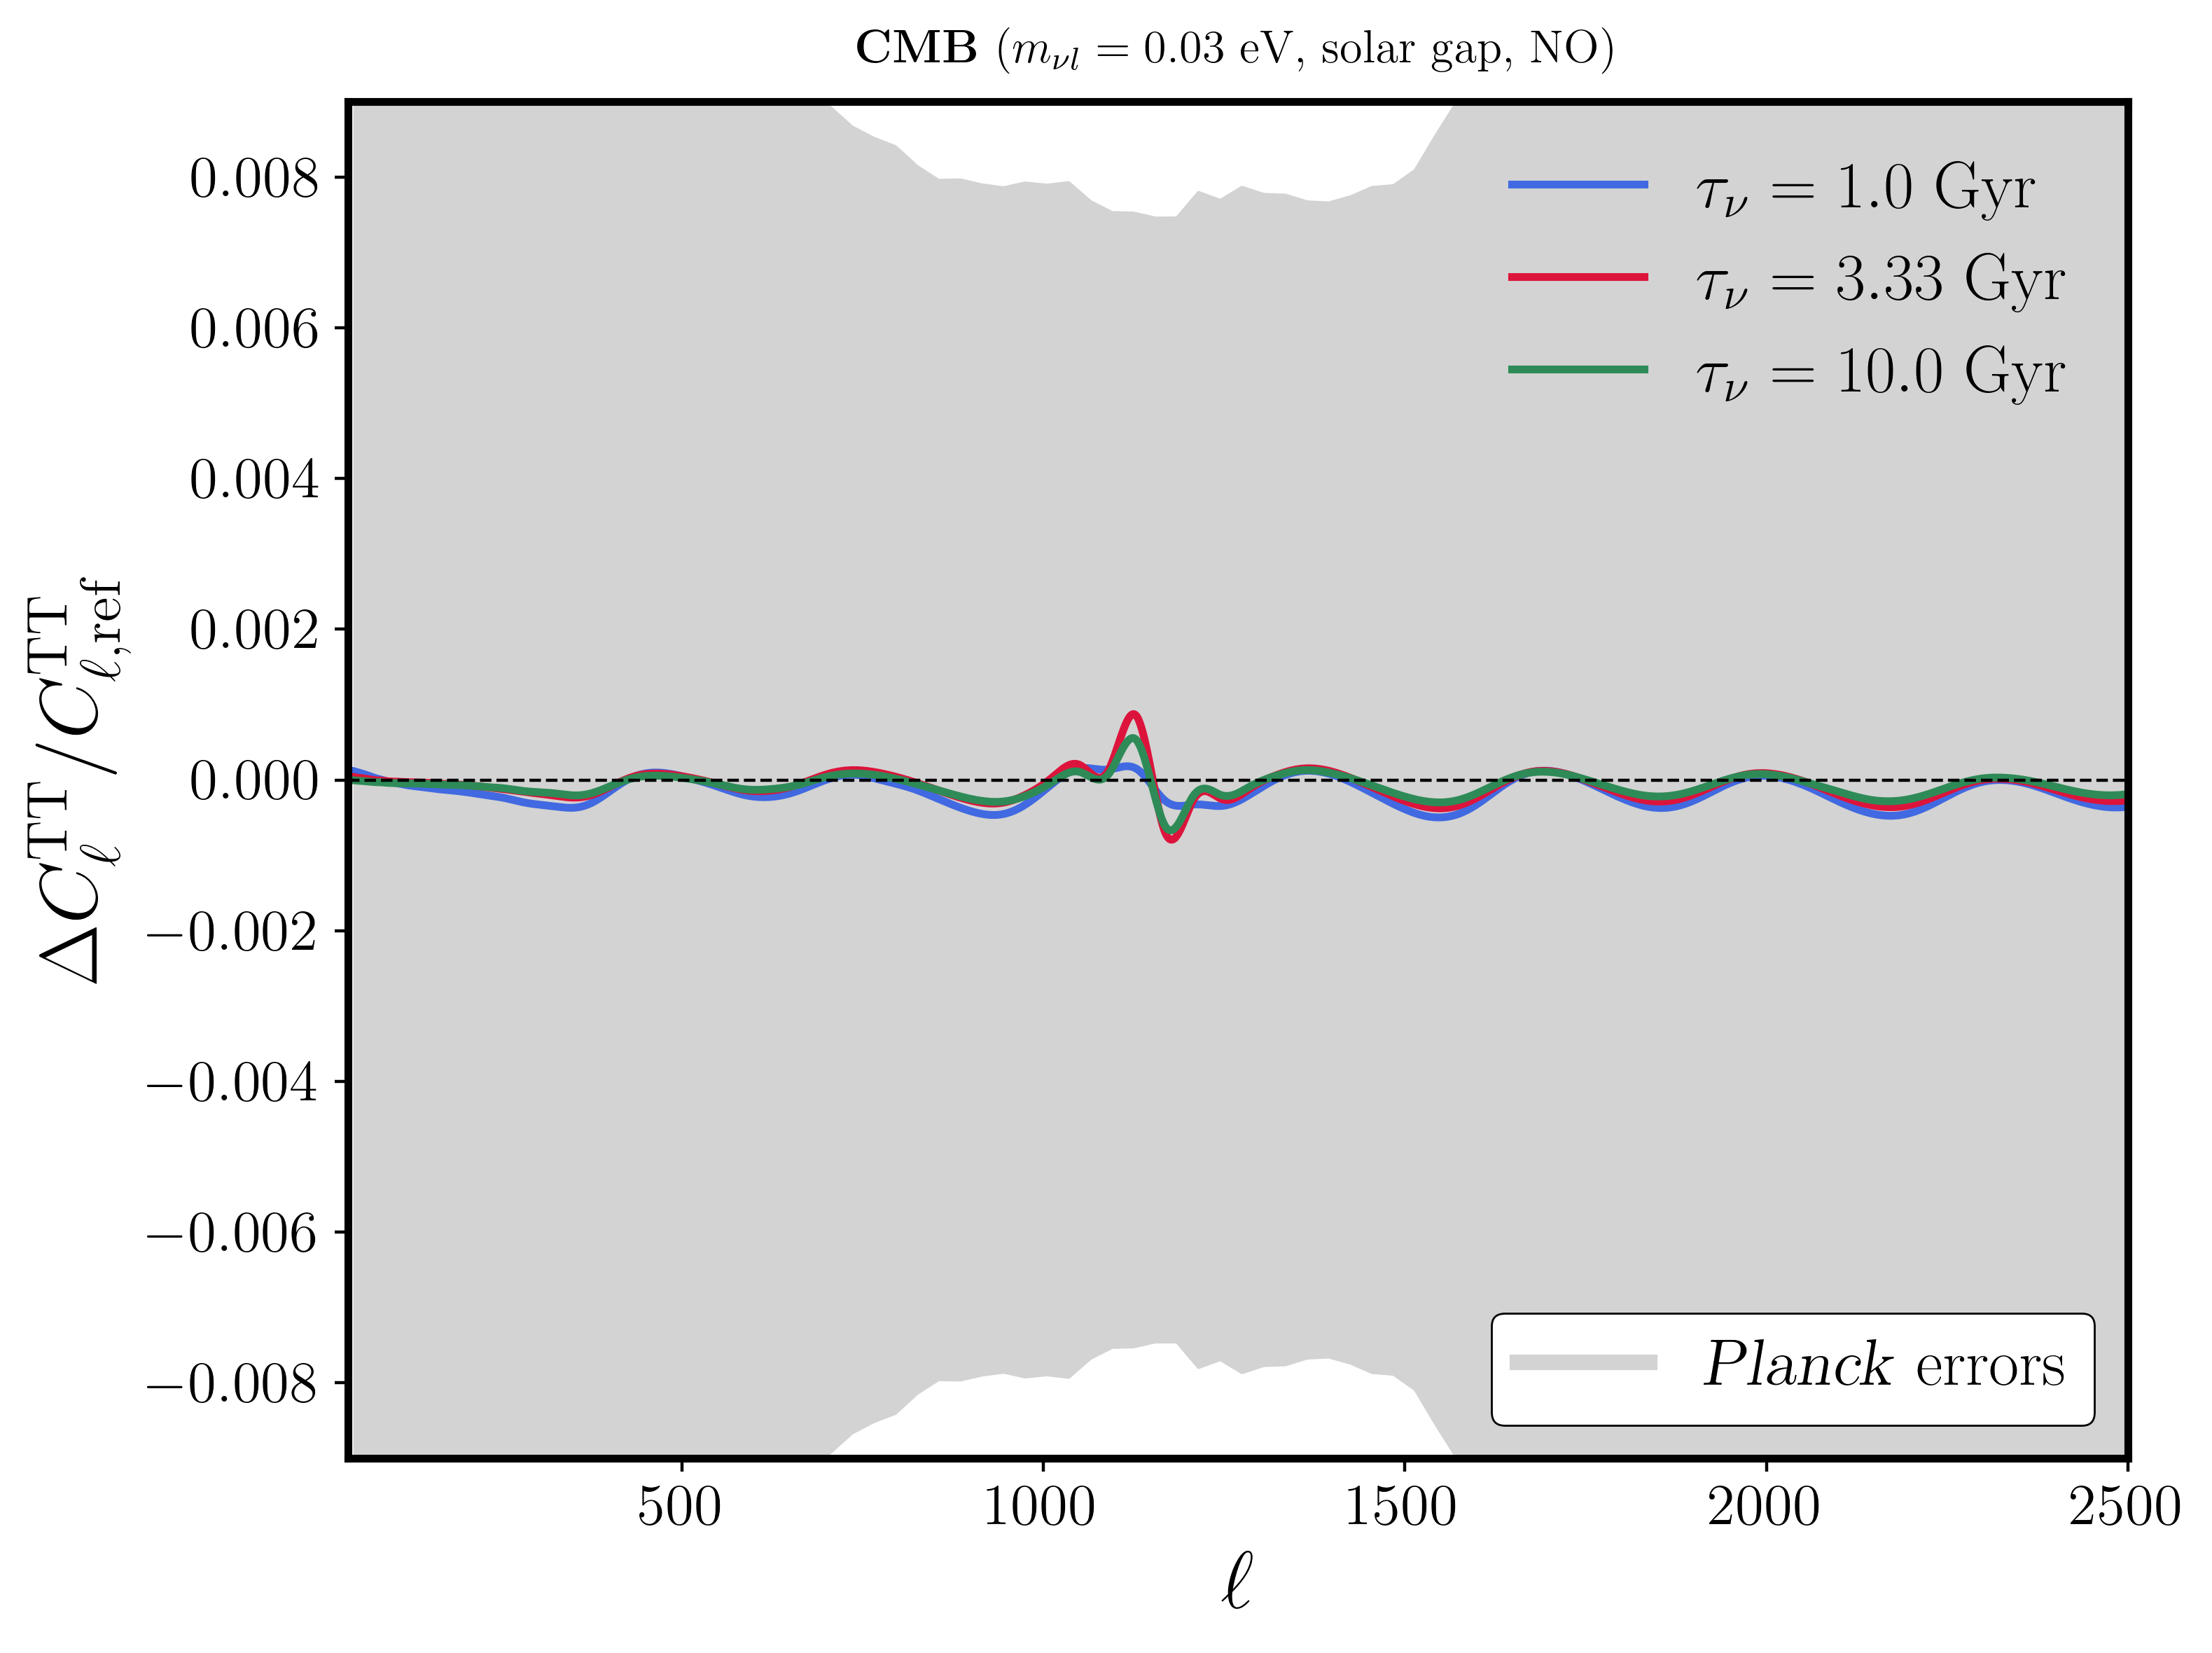

In [10]:
plt.figure(figsize=(8, 6), dpi=400)

plt.plot(l1,(Cl_TT1-Cl_TT0)/Cl_TT0, color='royalblue',  linewidth=2.0, label=r"$\tau_\nu = 1.0 \ \mathrm{Gyr}$")
plt.plot(l2,(Cl_TT2-Cl_TT0)/Cl_TT0,  color='crimson',  linewidth=2.0, label=r"$\tau_\nu = 3.33 \ \mathrm{Gyr}$")
plt.plot(l3,(Cl_TT3-Cl_TT0)/Cl_TT0, color='seagreen', linewidth=2.0, label=r"$\tau_\nu = 10.0 \ \mathrm{Gyr}$")

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(lTT, -(DlTT_error_plus)/DlTT_mean, +(DlTT_error_plus)/DlTT_mean, color='lightgray')

plt.xscale('linear')
#plt.xscale('log')
plt.yscale('linear')
plt.xlabel('$\\ell$')
plt.ylabel(r'$\Delta C_{\ell}^{\mathrm{TT}}/C_{\ell, \mathrm{ref}}^{\mathrm{TT}}$')
plt.title(r"{\bf{CMB}} ($m_{\nu l} = %.2f$ eV, solar gap, NO)"%m_nuL,pad=10)

plt.xlim(38, 2500)
#plt.xlim(2, 2500)

plt.ylim(-0.009, 0.009)
plt.grid(False)
plt.tight_layout()

legend1 = plt.legend(frameon=False, loc='upper right')
ax = plt.gca()
ax.add_artist(legend1)

[x.set_linewidth(2.0) for x in plt.gca().spines.values()]

lines = [Line2D([0], [0], color='lightgray', linewidth=4, linestyle='-')]
labels = [r'\textsl{Planck} errors']
legend2 = plt.legend(lines, labels,loc='lower right',frameon=True, 
           facecolor='white',edgecolor='black',framealpha=1.0)
legend2.get_frame().set_linewidth(0.5)

plt.savefig('plots_residuals/CMB_residuals_A2.pdf')

plt.show()

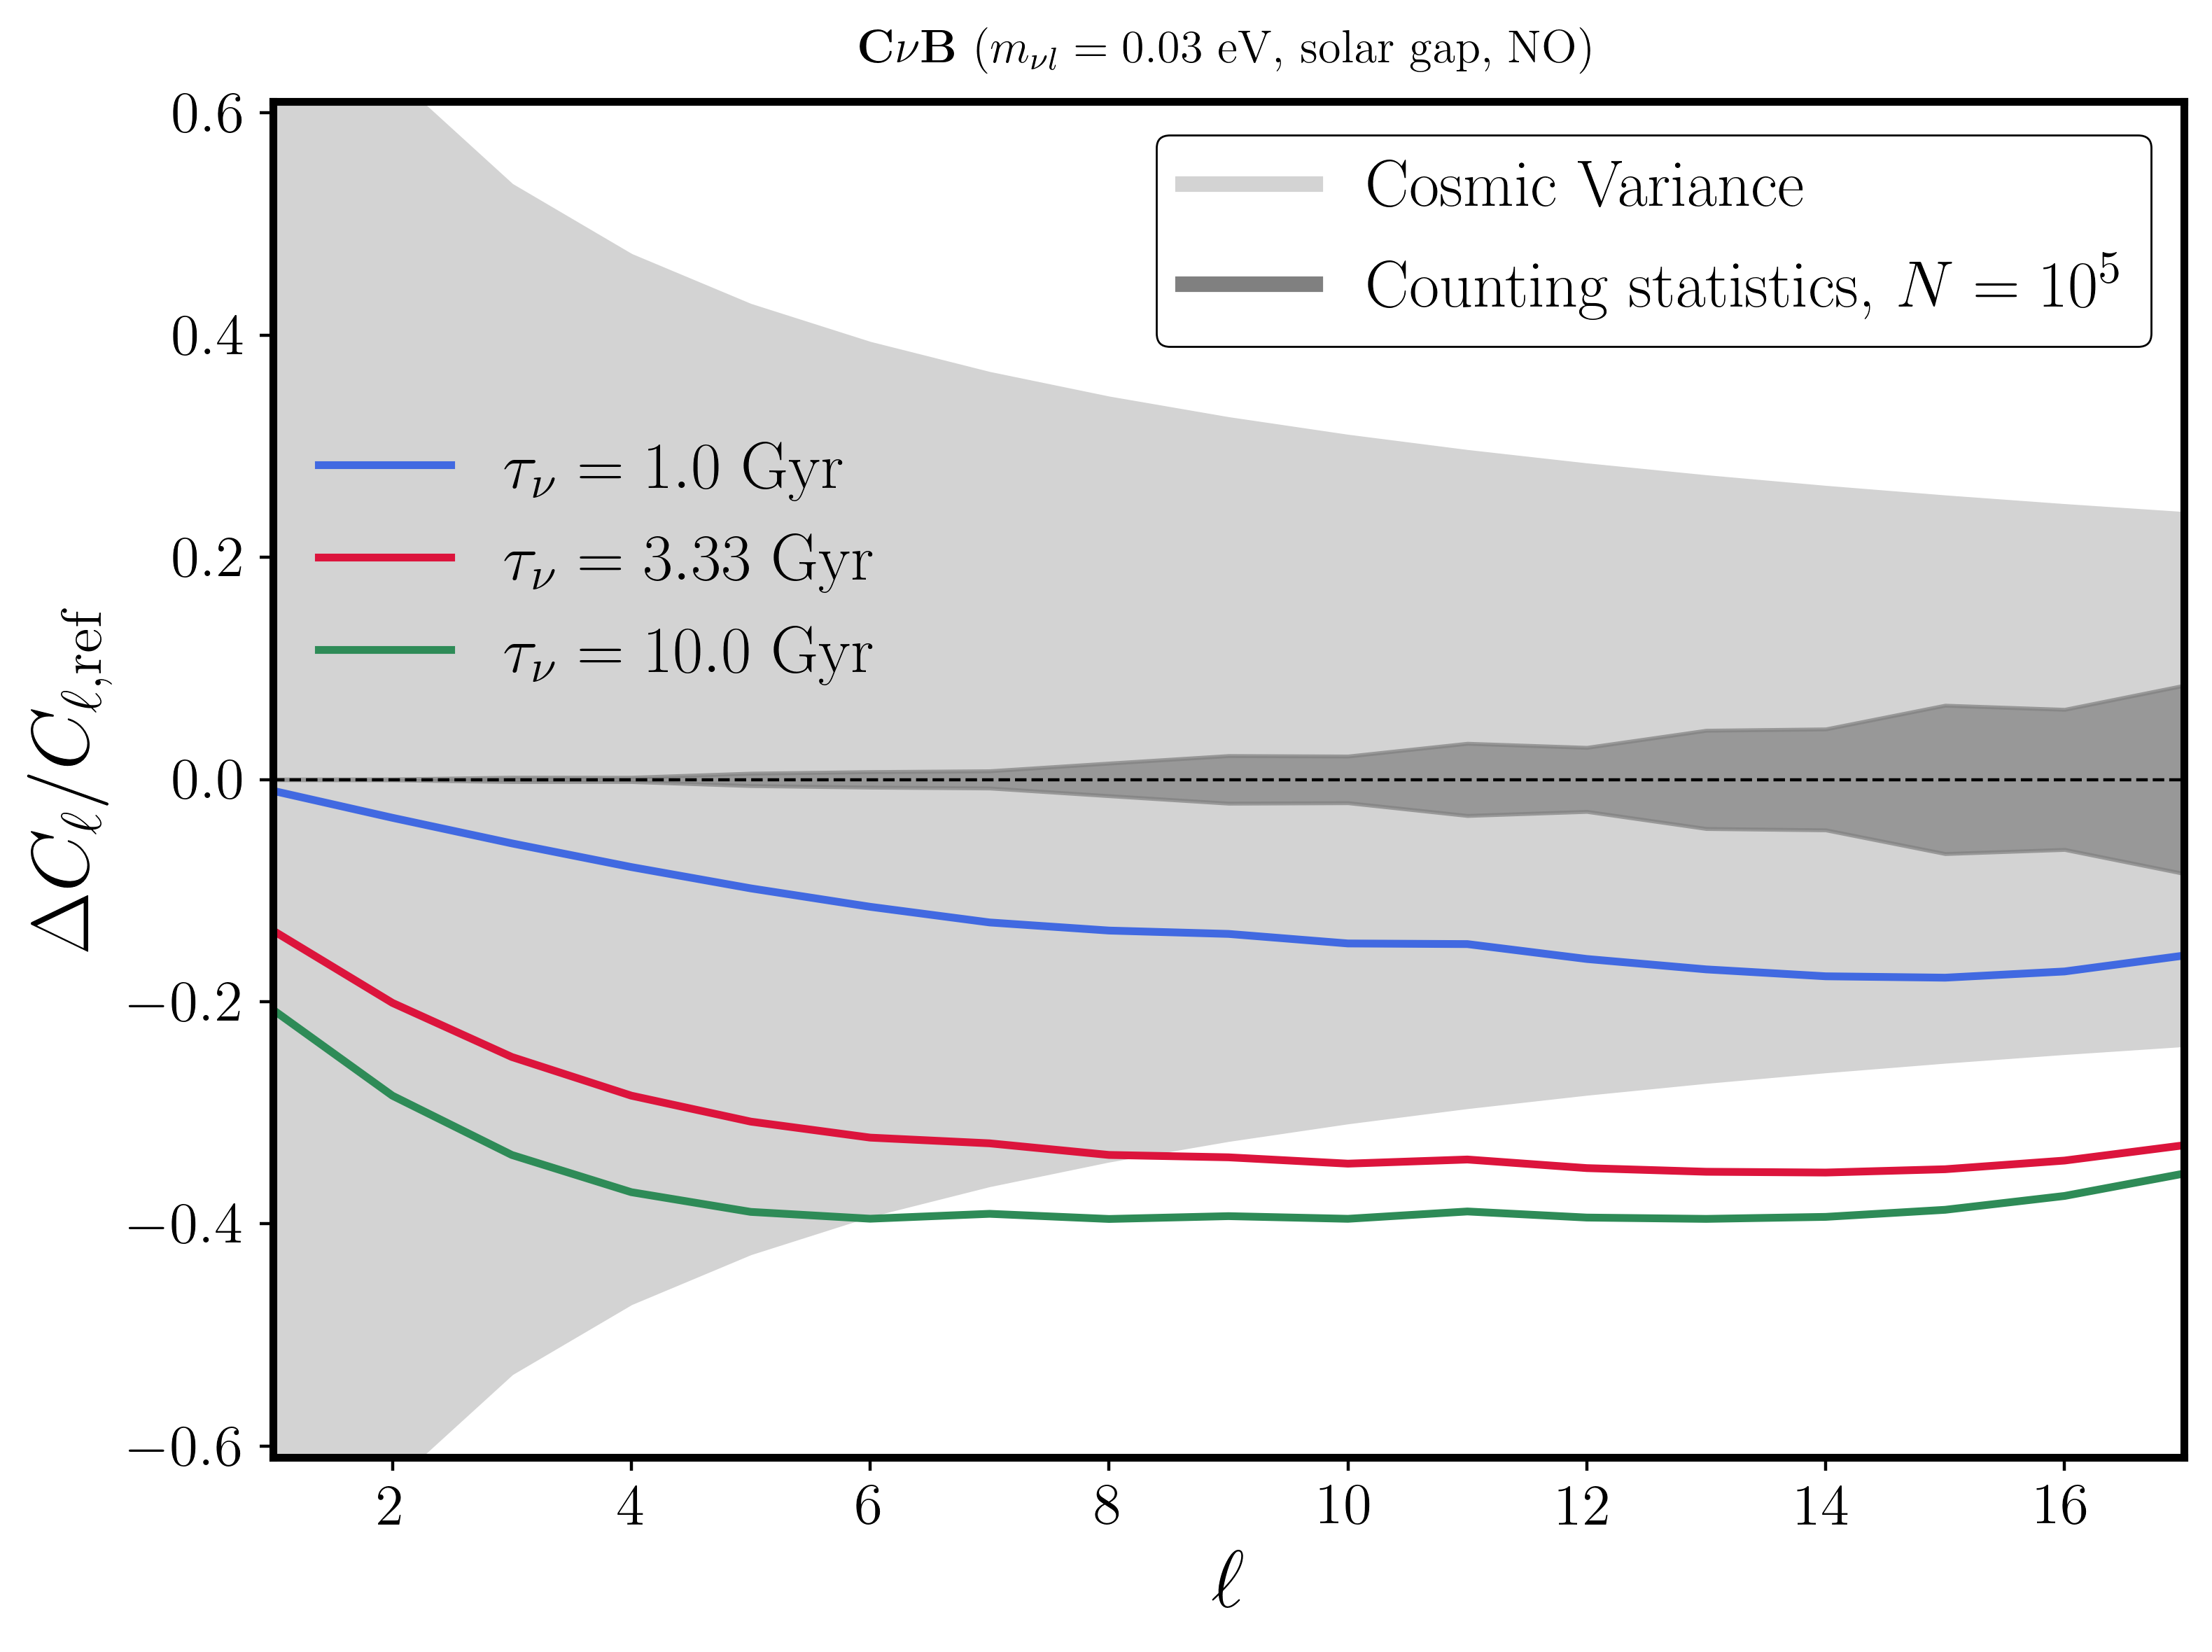

In [11]:
plt.figure(figsize=(8, 6), dpi=400)

l_high = 18
ell = np.arange(1, l_high)

res1_smooth = savgol_filter((Cl_avg1[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)
res2_smooth = savgol_filter((Cl_avg2[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)
res3_smooth = savgol_filter((Cl_avg3[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)

plt.plot(ell,res1_smooth,color='royalblue',  linewidth=2.0,label=r"$\tau_\nu = 1.0 \ \mathrm{Gyr}$")
plt.plot(ell,res2_smooth,color='crimson' ,  linewidth=2.0,label=r"$\tau_\nu = 3.33 \ \mathrm{Gyr}$")
plt.plot(ell,res3_smooth,color='seagreen', linewidth=2.0,label=r"$\tau_\nu = 10.0 \ \mathrm{Gyr}$")

#plt.plot(ell,(Cl_avg1[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='blue', linewidth=1.5,label=r"$\Gamma = 1.0 \ \mathrm{Gyr}^{-1}$")
#plt.plot(ell,(Cl_avg2[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='red' , linewidth=1.5,label=r"$\Gamma = 0.3 \ \mathrm{Gyr}^{-1}$")
#plt.plot(ell,(Cl_avg3[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='green',linewidth=1.5,label=r"$\Gamma = 0.1 \ \mathrm{Gyr}^{-1}$")


plt.fill_between(ell, -np.sqrt(2./(2*ell+1.)), +np.sqrt(2./(2*ell+1.)), color='lightgray')
plt.fill_between(ell, -cl_std/Cl_avg0[1:], cl_std/Cl_avg0[1:], alpha=0.7, color='gray') 
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

plt.yscale('linear')
plt.xscale('linear')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_{\ell} / C_{\ell, \mathrm{ref}}$')
plt.title(r"{\bf{C$\nu$B}} ($m_{\nu l} = %.2f$ eV, solar gap, NO)"%m_nuL,pad=10)

plt.xlim(1, 17)
plt.ylim(-0.61, 0.61)
plt.tight_layout()
plt.grid(False)

legend1 = plt.legend(frameon=False, loc=(0.01,0.55))
ax = plt.gca()
ax.add_artist(legend1)

[x.set_linewidth(2.0) for x in plt.gca().spines.values()]


lines = [Line2D([0], [0], color='lightgray', linewidth=4, linestyle='-'),
         Line2D([0], [0], color='gray', linewidth=4, linestyle='-')]

labels = [r'Cosmic Variance',r'Counting statistics, $N=10^5$']
legend2 = plt.legend(lines, labels,loc="upper right",frameon=True, 
           facecolor='white',edgecolor='black',framealpha=1.0)
legend2.get_frame().set_linewidth(0.5)


plt.savefig('plots_residuals/CNB_residuals_A2.pdf')

plt.show()